In [ ]:
%pylab inline
import rlcompleter, readline
readline.parse_and_bind('tab: complete')
import findspark
import os
findspark.init()
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc = SparkContext()
sqlContext = SQLContext(sc)

In [34]:
import itertools
from pyspark.mllib.recommendation import ALS
from pyspark.mllib.evaluation import RegressionMetrics


In [138]:
def parseRatings(l):
    """
    Parse the Ratings
    """
    return int(l[0]), int(l[1]), float(l[2])




def findMovieTitles(ids, movies):
    """
    Find movie title from movie id
    """
    titles = [movies.filter(lambda x: x[0] == i).map(lambda x: x[1]).collect() for i in ids]
    return titles




def computeRmse(model, data, n):
    """
    Compute RMSE (Root Mean Squared Error).
    """
    predictions = model.predictAll(data.map(lambda x: (x[0], x[1])))
    predictionsAndRatings = predictions.map(lambda x: ((x[0], x[1]), x[2])) \
      .join(data.map(lambda x: ((x[0], x[1]), x[2]))) \
      .values()
    return sqrt(predictionsAndRatings.map(lambda x: (x[0] - x[1]) ** 2).reduce(add) / float(n))





def findBestModel(train, validation, ranks, lambdas, iteration):
    """
    Choose Regularization and number of latent factors 
    """
    bestModel = None
    bestLambda = -1.0
    bestRank = 0
    bestRmse = float("inf")
    
    for rank, lmbda in itertools.product(ranks, lambdas):
        model = ALS.train(train, rank, iteration, lmbda)
        rmse = computeRmse(model, validation, validation.count())
        
        print("model trained with lambda = ", lmbda, "rank = ", rank, "has the rmse = ", rmse)
        
        if rmse < bestRmse:
            bestRmse = rmse
            bestModel = model
            bestLambda = lmbda
            bestRank = rank
            
            
    return bestModel, bestRmse





def evaluateOnTest(model, test):
    """
    Evaluate the model on testing set
    """
    rmse = computeRmse(model, test, test.count())
    print("the RMSE for best trained model on test set is", rmse)
    return rmse





def recommendation_engine(model, user_data, movieList):
    """
    Build a recommendation engine 
    """
    userid = user_data.first()[0]
    watchedMovies = user_data.map(lambda x: x[1])
    recommendList = movieList.subtract(watchedMovies) 
    predictions = model.predictAll(recommendList.map(lambda x : (userid, x))).collect()
    recommendations = findMovieTitles(\
                                    [sorted(predictions, key=lambda x: x[2], reverse=True)[i].product for i in range(10)],\
                                    movies)
    
    print ("Movies recommended for user:", userid)
    for each in recommendations:
        print(each)
    
    return predictions

In [44]:
movies = sc.textFile('../data/ml-10M100K/movies.dat')\
                    .map(lambda x: x.split('::'))\
                    .map(lambda x: [int(x[0]), str(x[1]), str(x[2])])
train = sc.textFile('../data/sorted_ratings/train.txt')\
                    .map(lambda x:x.strip('[').strip(']').split(','))\
                    .map(lambda x: parseRatings(x))
validation = sc.textFile('../data/sorted_ratings/validation.txt')\
                    .map(lambda x:x.strip('[').strip(']').split(','))\
                    .map(lambda x: parseRatings(x))
test = sc.textFile('../data/sorted_ratings/test.txt')\
                    .map(lambda x:x.strip('[').strip(']').split(','))\
                    .map(lambda x: parseRatings(x))

In [33]:
ranks = [8, 12, 16]
lambdas = [0.01, 0.1, 1.0, 10.0]
iteration = 10
bestModel, bestRmse = findBestModel(train, validation, ranks, lambdas, iteration)

model trained with lambda =  0.01 rank =  8 has the rmse =  0.277256291228
model trained with lambda =  0.1 rank =  8 has the rmse =  0.266630315546
model trained with lambda =  1.0 rank =  8 has the rmse =  0.426217324786
model trained with lambda =  10.0 rank =  8 has the rmse =  1.24796163803
model trained with lambda =  0.01 rank =  12 has the rmse =  0.281615683625
model trained with lambda =  0.1 rank =  12 has the rmse =  0.266209477209
model trained with lambda =  1.0 rank =  12 has the rmse =  0.426216209265
model trained with lambda =  10.0 rank =  12 has the rmse =  1.24796163803
model trained with lambda =  0.01 rank =  16 has the rmse =  0.285915329906
model trained with lambda =  0.1 rank =  16 has the rmse =  0.266482002457
model trained with lambda =  1.0 rank =  16 has the rmse =  0.42621612179
model trained with lambda =  10.0 rank =  16 has the rmse =  1.24796163803


In [64]:
testRmse = evaluateOnTest(bestModel, test)

the RMSE for best trained model on test set is 0.148921422515


In [139]:
movieList = train.map(lambda x: x[1]).distinct()
user_data = train.filter(lambda x: x[0] == 36955).map(lambda x: (x[0], x[1]))
prediction = recommendation_engine(bestModel, user_data, movieList)

Movies recommended for user: 36955
['Shawshank Redemption, The (1994)']
["Schindler's List (1993)"]
['Usual Suspects, The (1995)']
['Lord of the Rings: The Return of the King, The (2003)']
['House with Laughing Windows, The (La Casa dalle Finestre che Ridono) (1976)']
['Silence of the Lambs, The (1991)']
['Godfather, The (1972)']
['Gloomy Sunday (Ein Lied von Liebe und Tod) (1999)']
['Wallace & Gromit: The Wrong Trousers (1993)']
['Wallace & Gromit: The Best of Aardman Animation (1996)']


In [157]:
rank_8 = np.asarray([[0.01, 0.277256291228],\
          [0.1, 0.266630315546],\
          [1.0, 0.426217324786],\
          [10.0, 1.24796163803]
         ])
rank_12 = np.asarray([[0.01, 0.281615683625],\
          [0.1, 0.266209477209],\
          [1.0, 0.426216209265],\
          [10.0, 1.24796163803]
         ])
rank_16 = np.asarray([[0.01, 0.285915329906],\
          [0.1, 0.266482002457],\
          [1.0, 0.42621612179],\
          [10.0, 1.24796163803]
         ])


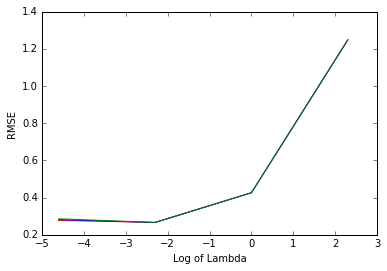

In [169]:
plt.plot(np.log(rank_8[:,0]), rank_8[:,1],color='r')
plt.xlabel('Log of Lambda')
plt.ylabel('RMSE')
plt.plot(np.log(rank_12[:,0]), rank_12[:,1], color='b')
plt.plot(np.log(rank_16[:,0]), rank_16[:,1], color='g')